In [1]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [3]:
pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425344 sha256=dee77be6907aa1fc5aa7d6e43a25b83464482bd06d4752e75932a1c269bdea50
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


In [4]:
import pyspark
from pyspark.sql import SparkSession
# creating spark session
spark_session = SparkSession.builder\
.appName('Twitter Analysis')\
.getOrCreate()

In [5]:
#reading twitter data
twitter_data = spark_session.read.option("header","true").option("inferSchema","true").csv('/content/drive/MyDrive/corona/covid_19.csv')

In [7]:
twitter_data.show(50)

+--------------------+--------------------+--------------------+
|               title|                link|               tweet|
+--------------------+--------------------+--------------------+
|     Minority Health|https://twitter.c...|Mar 10, 2023 — If...|
|             Novavax|https://twitter.c...|Jun 7, 2023 — rec...|
|         UCSF Health|https://mobile.tw...|"May 12, 2023 — T...|
|             UN News|https://twitter.c...|Jan 10, 2023 — CO...|
|      Nada Al-Nashif|https://twitter.c...|May 31, 2023 — #C...|
|                 AMA|https://mobile.tw...|Jul 14, 2023 — Ag...|
|Active - #COVID -...|https://twitter.c...|Apr 12, 2023 — Co...|
|Governor Kathy Ho...|https://twitter.c...|Jan 11, 2022 — #C...|
|Lara Jirmanus, MD...|https://twitter.c...|"Apr 23, 2023 — #...|
|   Homeland Security|https://twitter.c...|Dec 29, 2021 — Wi...|
|6:59 PM · Apr 20,...|https://twitter.c...|Apr 20, 2022 — Da...|
|                 NIH|https://twitter.c...|Feb 11, 2022 — #C...|
|Active - #COVID -...|htt

In [8]:
twitter_data.printSchema()

root
 |-- title: string (nullable = true)
 |-- link: string (nullable = true)
 |-- tweet: string (nullable = true)



In [9]:
# counting number of tweets

num_tweets = twitter_data.count()
print(f'total tweets available: {num_tweets}')

total tweets available: 755


In [10]:
# calculating average length of the tweet
avg_tweet_length = twitter_data.selectExpr('avg(length(tweet))').collect()[0][0]
print(f'average length of tweets : {avg_tweet_length}')

average length of tweets : 148.83576158940397


In [11]:
#counting how many time each hashtag occured in tweet

from pyspark.sql.functions import split, explode

# tweet is a column containing text with hashtags
# Split the text into an array of words
twitter_data = twitter_data.withColumn("words", split("tweet", " "))

# Explode the array to get one row per word
hashtags = twitter_data.select(explode("words").alias("hashtag"))

# Filter for rows that start with a hashtag (#)
hashtags = hashtags.filter(hashtags.hashtag.startswith("#"))

# Group and count hashtags
hashtag_counts = hashtags.groupBy("hashtag").count().sort("count", ascending=False)


In [12]:
hashtag_counts.show(10)
# number of time different hashtag occured in the data set
# showing top 10 hashtags

+-------------------+-----+
|            hashtag|count|
+-------------------+-----+
|           #COVID19|  133|
|             #COVID|   89|
|        #WuhanVirus|   79|
|    #CoronaOutbreak|   73|
|#CoronavirusVaccine|   57|
|       #coronavirus|   43|
|  #CoronavirusIndia|   38|
|  #coronavirusindia|   37|
|  #coronaviruscases|   35|
|  #CoronavirusCases|   27|
+-------------------+-----+
only showing top 10 rows



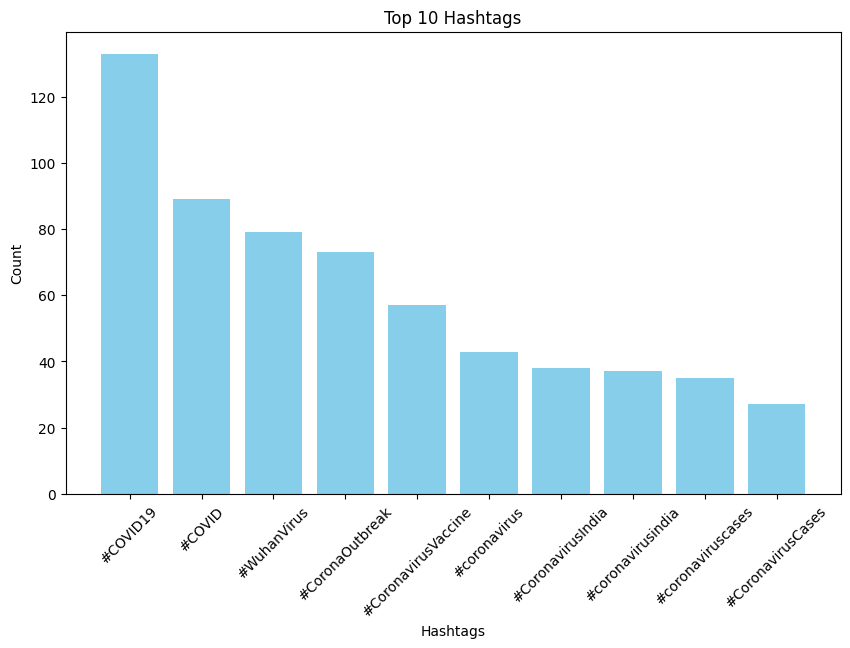

In [13]:
import matplotlib.pyplot as plt

# Assuming 'hashtag_counts' is the DataFrame with hashtags and their counts
top_hashtags = hashtag_counts.limit(10).toPandas()  # Convert to Pandas for easy plotting

# Plot the top hashtags
plt.figure(figsize=(10, 6))
plt.bar(top_hashtags['hashtag'], top_hashtags['count'], color='skyblue')
plt.xlabel('Hashtags')
plt.ylabel('Count')
plt.title('Top 10 Hashtags')
plt.xticks(rotation=45)
plt.show()


# converting tweet to lower case

In [14]:
#before conversion
twitter_data.select('tweet').show(10)

+--------------------+
|               tweet|
+--------------------+
|Mar 10, 2023 — If...|
|Jun 7, 2023 — rec...|
|"May 12, 2023 — T...|
|Jan 10, 2023 — CO...|
|May 31, 2023 — #C...|
|Jul 14, 2023 — Ag...|
|Apr 12, 2023 — Co...|
|Jan 11, 2022 — #C...|
|"Apr 23, 2023 — #...|
|Dec 29, 2021 — Wi...|
+--------------------+
only showing top 10 rows



In [15]:
# converting to lower case
from pyspark.sql.functions import col, lower

cleaned_text = twitter_data.select(lower(col("tweet")).alias("cleaned_text"))

In [16]:
cleaned_text.show()

+--------------------+
|        cleaned_text|
+--------------------+
|mar 10, 2023 — if...|
|jun 7, 2023 — rec...|
|"may 12, 2023 — t...|
|jan 10, 2023 — co...|
|may 31, 2023 — #c...|
|jul 14, 2023 — ag...|
|apr 12, 2023 — co...|
|jan 11, 2022 — #c...|
|"apr 23, 2023 — #...|
|dec 29, 2021 — wi...|
|apr 20, 2022 — da...|
|feb 11, 2022 — #c...|
|apr 13, 2023 — #c...|
|may 2, 2023 — #co...|
|jan 17, 2023 — #c...|
|apr 19, 2022 — wh...|
|mar 29, 2022 — da...|
|feb 16, 2022 — na...|
|jan 1, 2022 — #co...|
|dec 1, 2021 — the...|
+--------------------+
only showing top 20 rows



# creating user define function to convert the tweet into upper case

In [17]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

@udf(StringType())
def custom_function(text):
    return text.upper()

udf_data = twitter_data.withColumn("snippet_upper_case", custom_function(twitter_data['tweet']))

In [18]:
udf_data.show()

+--------------------+--------------------+--------------------+--------------------+--------------------+
|               title|                link|               tweet|               words|  snippet_upper_case|
+--------------------+--------------------+--------------------+--------------------+--------------------+
|     Minority Health|https://twitter.c...|Mar 10, 2023 — If...|[Mar, 10,, 2023, ...|MAR 10, 2023 — IF...|
|             Novavax|https://twitter.c...|Jun 7, 2023 — rec...|[Jun, 7,, 2023, —...|JUN 7, 2023 — REC...|
|         UCSF Health|https://mobile.tw...|"May 12, 2023 — T...|["May, 12,, 2023,...|"MAY 12, 2023 — T...|
|             UN News|https://twitter.c...|Jan 10, 2023 — CO...|[Jan, 10,, 2023, ...|JAN 10, 2023 — CO...|
|      Nada Al-Nashif|https://twitter.c...|May 31, 2023 — #C...|[May, 31,, 2023, ...|MAY 31, 2023 — #C...|
|                 AMA|https://mobile.tw...|Jul 14, 2023 — Ag...|[Jul, 14,, 2023, ...|JUL 14, 2023 — AG...|
|Active - #COVID -...|https://twitter

# extracting the data which was tweeted on the year 2020 only

In [21]:
from pyspark.sql.functions import col, expr

# Assuming 'twitter_data' is your DataFrame
filtered_tweets_2020 = twitter_data.filter(expr("tweet LIKE '%2020%'"))
filtered_tweets_2020.show(10)

+--------------------+--------------------+--------------------+--------------------+
|               title|                link|               tweet|               words|
+--------------------+--------------------+--------------------+--------------------+
|             UN News|https://twitter.c...|Sep 15, 2020 — #C...|[Sep, 15,, 2020, ...|
|Johnny C. Taylor,...|https://twitter.c...|Mar 19, 2020 — #C...|[Mar, 19,, 2020, ...|
|Arizona State Uni...|https://mobile.tw...|Jul 27, 2020 — #C...|[Jul, 27,, 2020, ...|
|  Mayor Kate Gallego|https://twitter.c...|Jun 12, 2020 — Fo...|[Jun, 12,, 2020, ...|
|     Larry Brilliant|https://twitter.c...|Nov 11, 2020 — To...|[Nov, 11,, 2020, ...|
|"""American Catas...|https://twitter.c...|Jul 24, 2020 — NE...|[Jul, 24,, 2020, ...|
|      EU Agriculture|https://twitter.c...|Apr 20, 2023 — In...|[Apr, 20,, 2023, ...|
|World Health Orga...|https://twitter.c...|Mar 28, 2020 — FA...|[Mar, 28,, 2020, ...|
|                 CDC|https://twitter.c...|Feb 25, 202

# sentiment analysis and word count how many time each word occured

In [22]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, explode, udf
from pyspark.sql.types import StringType
from textblob import TextBlob



# Sentiment Analysis
def get_sentiment(text):
    analysis = TextBlob(text)
    if analysis.sentiment.polarity > 0:
        return 'positive'
    elif analysis.sentiment.polarity == 0:
        return 'neutral'
    else:
        return 'negative'

sentiment_udf = udf(get_sentiment, StringType())
twitter_data = twitter_data.withColumn('sentiment', sentiment_udf(col('tweet')))

# Word Frequency Analysis
word_counts = twitter_data \
    .select(explode(split(col('tweet'), ' ')).alias('word')) \
    .groupBy('word') \
    .count() \
    .sort('count', ascending=False)

# Show top 10 words
word_counts.show(10)

# Show sentiment distribution
sentiment_distribution = twitter_data.groupBy('sentiment').count()
sentiment_distribution.show()

+----+-----+
|word|count|
+----+-----+
|   ·|  712|
|   —|  498|
| the|  372|
|2020|  276|
|  to|  252|
|2021|  192|
|  in|  185|
|  of|  182|
| and|  170|
| Mar|  133|
+----+-----+
only showing top 10 rows

+---------+-----+
|sentiment|count|
+---------+-----+
| positive|  289|
|  neutral|  383|
| negative|   83|
+---------+-----+



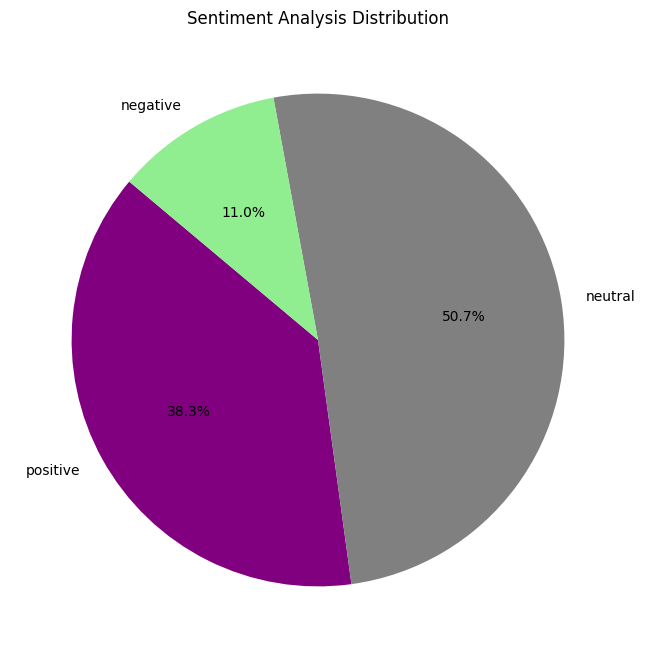

In [25]:
import matplotlib.pyplot as plt

sentiments = sentiment_distribution.select('sentiment', 'count').toPandas()

# Creating a pie chart
plt.figure(figsize=(8, 8))
plt.pie(sentiments['count'], labels=sentiments['sentiment'], autopct='%1.1f%%', startangle=140, colors=['purple', 'gray', 'lightgreen'])
plt.title('Sentiment Analysis Distribution')
plt.show()


In [30]:
twitter_data.show()

+--------------------+--------------------+--------------------+--------------------+---------+
|               title|                link|               tweet|               words|sentiment|
+--------------------+--------------------+--------------------+--------------------+---------+
|     Minority Health|https://twitter.c...|Mar 10, 2023 — If...|[Mar, 10,, 2023, ...|  neutral|
|             Novavax|https://twitter.c...|Jun 7, 2023 — rec...|[Jun, 7,, 2023, —...|  neutral|
|         UCSF Health|https://mobile.tw...|"May 12, 2023 — T...|["May, 12,, 2023,...|  neutral|
|             UN News|https://twitter.c...|Jan 10, 2023 — CO...|[Jan, 10,, 2023, ...|  neutral|
|      Nada Al-Nashif|https://twitter.c...|May 31, 2023 — #C...|[May, 31,, 2023, ...| negative|
|                 AMA|https://mobile.tw...|Jul 14, 2023 — Ag...|[Jul, 14,, 2023, ...| positive|
|Active - #COVID -...|https://twitter.c...|Apr 12, 2023 — Co...|[Apr, 12,, 2023, ...| negative|
|Governor Kathy Ho...|https://twitter.c.

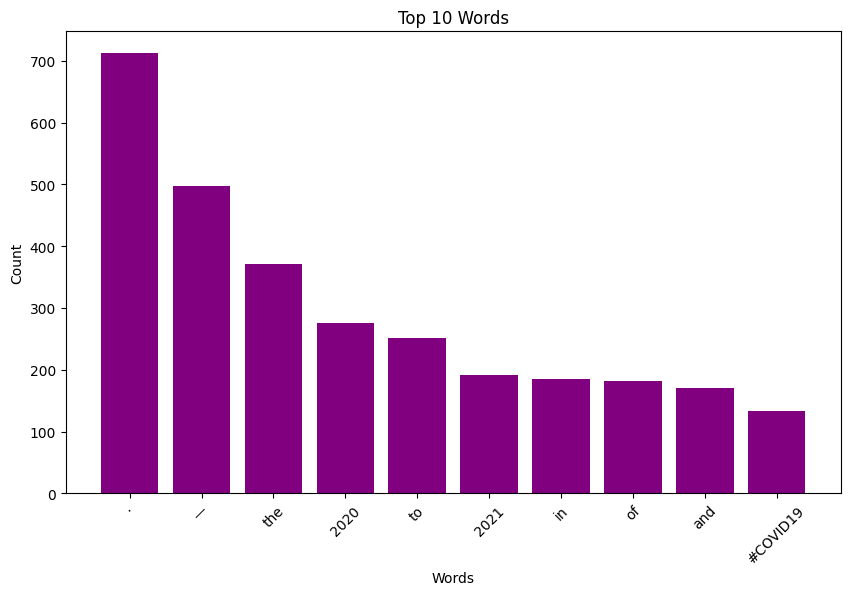

In [27]:
import matplotlib.pyplot as plt

# converting data to pandas for the ease of plotting
top_words = word_counts.limit(10).toPandas()

# Plot the top words
plt.figure(figsize=(10, 6))
plt.bar(top_words['word'], top_words['count'], color='purple')
plt.xlabel('Words')
plt.ylabel('Count')
plt.title('Top 10 Words')
plt.xticks(rotation=45)
plt.show()


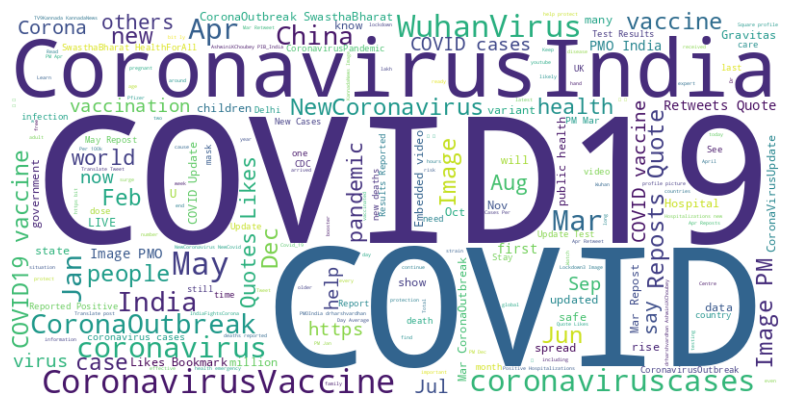

In [28]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Concatenate all tweet texts into a single string
all_tweets_text = ' '.join(twitter_data.select('tweet').rdd.flatMap(lambda x: x).collect())

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_tweets_text)

# Display the generated word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


# from the world cloud we can see most frequent used words in tweet are
- coronavirusindia
- covid19
- covid

In [38]:
from pyspark.sql.functions import col

# Filter tweets containing '#covid update' or '#covid news'
covid_update_tweets = twitter_data.filter((col('tweet').like('%#COVID Update%')) | (col('tweet').like('%#COVID cases%')))

# Show the filtered DataFrame
covid_update_tweets.select('tweet').show(truncate=False)


+------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|tweet                                                                                                                                                             |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|Jan 11, 2022 — #COVID Update: -261,620 Test Results Reported -48,686 Positives -18.61% Positive -12,540 Hospitalizations (+518) -160 new deaths reported by ...   |
|Dec 29, 2021 — With #COVID cases rising it's important to stay healthy and safe: Wash your hands often If you've tested positive, isolate and inform ...          |
|Jan 1, 2022 — #COVID Update: -384,365 Test Results Reported -85,476 Positives -22.24% Positive -8,451 Hospitalizations (+532) -88 new deaths reported by ...      |
|Jan 2, 20

In [42]:
from pyspark.sql.functions import udf, col
from pyspark.sql.types import StringType
import re

@udf(StringType())
def extract_date_and_update(text):
    # Define a regular expression pattern to match date and COVID updates
    pattern = r'(\d{4}-\d{2}-\d{2}).*?(\d{1,3}(?:,\d{3})*(?:\.\d+)?)\s?(?:million|thousand)?\s?COVID Update:'

    # Search for the pattern in the text
    matches = re.findall(pattern, text, flags=re.IGNORECASE)

    # If matches are found, return the first match as a string
    if matches:
        date, cases = matches[0]
        return f"Date: {date}, Update: {cases} COVID cases"
    else:
        return None

covid_updates_df = twitter_data.withColumn("covid_update", extract_date_and_update(col('tweet')))
covid_updates_df.show()


+--------------------+--------------------+--------------------+--------------------+---------+------------+
|               title|                link|               tweet|               words|sentiment|covid_update|
+--------------------+--------------------+--------------------+--------------------+---------+------------+
|     Minority Health|https://twitter.c...|Mar 10, 2023 — If...|[Mar, 10,, 2023, ...|  neutral|        NULL|
|             Novavax|https://twitter.c...|Jun 7, 2023 — rec...|[Jun, 7,, 2023, —...|  neutral|        NULL|
|         UCSF Health|https://mobile.tw...|"May 12, 2023 — T...|["May, 12,, 2023,...|  neutral|        NULL|
|             UN News|https://twitter.c...|Jan 10, 2023 — CO...|[Jan, 10,, 2023, ...|  neutral|        NULL|
|      Nada Al-Nashif|https://twitter.c...|May 31, 2023 — #C...|[May, 31,, 2023, ...| negative|        NULL|
|                 AMA|https://mobile.tw...|Jul 14, 2023 — Ag...|[Jul, 14,, 2023, ...| positive|        NULL|
|Active - #COVID -.

In [85]:
from pyspark.sql.functions import expr

# Assuming 'tweet' is a column in your DataFrame
twitter_data = twitter_data.withColumn("date", expr("substring(tweet, 1, 13)"))


In [86]:
twitter_data.show()

+--------------------+--------------------+--------------------+--------------------+---------+-------------+
|               title|                link|               tweet|               words|sentiment|         date|
+--------------------+--------------------+--------------------+--------------------+---------+-------------+
|     Minority Health|https://twitter.c...|Mar 10, 2023 — If...|[Mar, 10,, 2023, ...|  neutral|Mar 10, 2023 |
|             Novavax|https://twitter.c...|Jun 7, 2023 — rec...|[Jun, 7,, 2023, —...|  neutral|Jun 7, 2023 —|
|         UCSF Health|https://mobile.tw...|"May 12, 2023 — T...|["May, 12,, 2023,...|  neutral|"May 12, 2023|
|             UN News|https://twitter.c...|Jan 10, 2023 — CO...|[Jan, 10,, 2023, ...|  neutral|Jan 10, 2023 |
|      Nada Al-Nashif|https://twitter.c...|May 31, 2023 — #C...|[May, 31,, 2023, ...| negative|May 31, 2023 |
|                 AMA|https://mobile.tw...|Jul 14, 2023 — Ag...|[Jul, 14,, 2023, ...| positive|Jul 14, 2023 |
|Active - 

In [87]:
from pyspark.sql.functions import col

# Filter tweets containing '#covid update'
twitter_data = twitter_data.filter(col('tweet').like('%#COVID Update%')).withColumn('total covid case ',expr("substring(tweet, 32,7)"))

# Show the filtered DataFrame

In [88]:
twitter_data.show()

+--------------------+--------------------+--------------------+--------------------+---------+-------------+-----------------+
|               title|                link|               tweet|               words|sentiment|         date|total covid case |
+--------------------+--------------------+--------------------+--------------------+---------+-------------+-----------------+
|Governor Kathy Ho...|https://twitter.c...|Jan 11, 2022 — #C...|[Jan, 11,, 2022, ...| positive|Jan 11, 2022 |          261,620|
|Governor Kathy Ho...|https://twitter.c...|Jan 1, 2022 — #CO...|[Jan, 1,, 2022, —...| positive|Jan 1, 2022 —|          84,365 |
|Governor Kathy Ho...|https://twitter.c...|Jan 2, 2022 — #CO...|[Jan, 2,, 2022, —...| positive|Jan 2, 2022 —|          75,563 |
|                 FIU|https://twitter.c...|Jan 25, 2021 — #C...|[Jan, 25,, 2021, ...| positive|Jan 25, 2021 |          y Dr. E|
|Governor Kathy Ho...|https://twitter.c...|Aug 29, 2021 — #C...|[Aug, 29,, 2021, ...| positive|Aug 29, 2